## Check if cuda available

In [1]:
%%bash

nvidia-smi
# python -V
python3 -V
# which python
which python3
update-alternatives --install /usr/bin/python python /usr/bin/python3.10 1
python -V
python3 -V


Thu Apr 27 20:36:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.104      Driver Version: 528.78       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   47C    P8    14W /  80W |    847MiB /  6144MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
print(tf.test.is_built_with_cuda())

NameError: name 'tf' is not defined

In [3]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen

2023-04-27 20:36:52.408095: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-27 20:36:52.409856: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 20:36:52.449374: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 20:36:52.450431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 20:36:53.054525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.12.0


In [35]:
# !git clone https://github.com/tensorflow/models.git

In [36]:
!curl -L 'https://public.roboflow.com/ds/ZpYLqHeT0W?key=ZXfZLRnhsc' > './BCCD.v1-bccd.coco.zip'
!unzip -q -o './BCCD.v1-bccd.coco.zip' -d './BCC.v1-bccd.coco/'
!rm './BCCD.v1-bccd.coco.zip'

/usr/bin/sh: 1: curl: not found
/usr/bin/sh: 1: unzip: not found


In [5]:
%%bash
ls

BCC.v1-bccd.coco
bccd_coco_tfrecords
models
tf_official_models_tutorial.ipynb
trained_model


In [6]:
%cd ./models/

/tf/notebooks/tf_od_notebooks/models


Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'nvidia'
dirname: missing operand
Try 'dirname --help' for more information.


In [8]:
%%bash
TRAIN_DATA_DIR='../BCC.v1-bccd.coco/train'
TRAIN_ANNOTATION_FILE_DIR='../BCC.v1-bccd.coco/train/_annotations.coco.json'
OUTPUT_TFRECORD_TRAIN='../bccd_coco_tfrecords/train'

python -V
# Need to provide
  # 1. image_dir: where images are present
  # 2. object_annotations_file: where annotations are listed in json format
  # 3. output_file_prefix: where to write output convered TFRecords files
python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=${TRAIN_DATA_DIR} \
  --object_annotations_file=${TRAIN_ANNOTATION_FILE_DIR} \
  --output_file_prefix=$OUTPUT_TFRECORD_TRAIN \
  --num_shards=1

Python 3.10.6


2023-04-27 20:37:16.633629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-27 20:37:21.338926: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
I0427 20:37:21.342190 139880112469120 create_coco_tf_record.py:502] writing to output path: ../bccd_coco_tfrecords/train
I0427 20:37:21.506366 139880112469120 create_coco_tf_record.py:374] Building bounding box index.
I0427 20:37:21.508879 139880112469120 create_coco_tf_record.py:385] 0 images are missing bboxes.
I0427 20:37:21.849190 139880112469120 tfrecord_lib.py:168] On image 0
I0427 20:37:21.877469 139880112469120 tfrecord_lib.py:168] On image 100
I0427 20:37:21.904972 139

In [9]:
%%bash

VALID_DATA_DIR='../BCC.v1-bccd.coco/valid'
VALID_ANNOTATION_FILE_DIR='../BCC.v1-bccd.coco/valid/_annotations.coco.json'
OUTPUT_TFRECORD_VALID='../bccd_coco_tfrecords/valid'

python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=$VALID_DATA_DIR \
  --object_annotations_file=$VALID_ANNOTATION_FILE_DIR \
  --output_file_prefix=$OUTPUT_TFRECORD_VALID \
  --num_shards=1

2023-04-27 20:37:23.404396: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-27 20:37:26.616890: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
I0427 20:37:26.618332 140163351381120 create_coco_tf_record.py:502] writing to output path: ../bccd_coco_tfrecords/valid
I0427 20:37:26.633835 140163351381120 create_coco_tf_record.py:374] Building bounding box index.
I0427 20:37:26.634141 140163351381120 create_coco_tf_record.py:385] 0 images are missing bboxes.
I0427 20:37:26.832749 140163351381120 tfrecord_lib.py:168] On image 0
I0427 20:37:26.877409 140163351381120 tfrecord_lib.py:180] Finished writing, skipped 0 annotation

In [10]:
%%bash


TEST_DATA_DIR='../BCC.v1-bccd.coco/test'
TEST_ANNOTATION_FILE_DIR='../BCC.v1-bccd.coco/test/_annotations.coco.json'
OUTPUT_TFRECORD_TEST='../bccd_coco_tfrecords/test'

python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=$TEST_DATA_DIR \
  --object_annotations_file=$TEST_ANNOTATION_FILE_DIR \
  --output_file_prefix=$OUTPUT_TFRECORD_TEST \
  --num_shards=1

2023-04-27 20:37:36.116266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-27 20:37:39.017695: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
I0427 20:37:39.019048 140500533548160 create_coco_tf_record.py:502] writing to output path: ../bccd_coco_tfrecords/test
I0427 20:37:39.031183 140500533548160 create_coco_tf_record.py:374] Building bounding box index.
I0427 20:37:39.031419 140500533548160 create_coco_tf_record.py:385] 0 images are missing bboxes.
I0427 20:37:39.110379 140500533548160 tfrecord_lib.py:168] On image 0
I0427 20:37:39.129303 140500533548160 tfrecord_lib.py:180] Finished writing, skipped 0 annotations

In [11]:
train_data_input_path = '../bccd_coco_tfrecords/train-00000-of-00001.tfrecord'
valid_data_input_path = '../bccd_coco_tfrecords/valid-00000-of-00001.tfrecord'
test_data_input_path = '../bccd_coco_tfrecords/test-00000-of-00001.tfrecord'
model_dir = '../trained_model/'
export_dir ='../exported_model/'

In [12]:
exp_config = exp_factory.get_exp_config('retinanet_resnetfpn_coco')

In [13]:
batch_size = 8
num_classes = 3

HEIGHT, WIDTH = 256, 256
IMG_SIZE = [HEIGHT, WIDTH, 3]

# Backbone config.
exp_config.task.freeze_backbone = False
exp_config.task.annotation_file = ''

# Model config.
exp_config.task.model.input_size = IMG_SIZE
exp_config.task.model.num_classes = num_classes + 1
exp_config.task.model.detection_generator.tflite_post_processing.max_classes_per_detection = exp_config.task.model.num_classes

# Training data config.
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = batch_size
exp_config.task.train_data.parser.aug_scale_max = 1.0
exp_config.task.train_data.parser.aug_scale_min = 1.0

# Validation data config.
exp_config.task.validation_data.input_path = valid_data_input_path
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.global_batch_size = batch_size

In [14]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'


train_steps = 1000
exp_config.trainer.steps_per_loop = 100 # steps_per_loop = num_of_training_examples // train_batch_size

exp_config.trainer.summary_interval = 100
exp_config.trainer.checkpoint_interval = 100
exp_config.trainer.validation_interval = 100
exp_config.trainer.validation_steps =  100 # validation_steps = num_of_validation_examples // eval_batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 100
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.1
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 0.05

Running on CPU is slow, so only train for a few steps.


2023-04-27 20:37:44.198595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-27 20:37:44.198912: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
pp.pprint(exp_config.as_dict())
display.Javascript('google.colab.output.setIframeHeight("500px");')

{   'runtime': {   'all_reduce_alg': None,
                   'batchnorm_spatial_persistent': False,
                   'dataset_num_private_threads': None,
                   'default_shard_dim': -1,
                   'distribution_strategy': 'mirrored',
                   'enable_xla': False,
                   'gpu_thread_mode': None,
                   'loss_scale': None,
                   'mixed_precision_dtype': 'bfloat16',
                   'num_cores_per_replica': 1,
                   'num_gpus': 0,
                   'num_packs': 1,
                   'per_gpu_thread_count': 0,
                   'run_eagerly': False,
                   'task_index': -1,
                   'tpu': None,
                   'tpu_enable_xla_dynamic_padder': None,
                   'worker_hosts': None},
    'task': {   'allow_image_summary': False,
                'annotation_file': '',
                'differential_privacy_config': None,
                'export_config': {   'cast_detection_c

<IPython.core.display.Javascript object>

In [16]:
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print('Done')

Done


In [17]:
with distribution_strategy.scope():
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

In [18]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  print()
  print(f'images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}')
  print(f'labels.keys: {labels.keys()}')

2023-04-27 20:37:57.453802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'cond/range/strided_slice' with dtype int32
	 [[{{node cond/range/strided_slice}}]]
2023-04-27 20:37:59.788167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-04-27 20:37:59.788380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 


images.shape: (8, 256, 256, 3)  images.dtype: tf.float32
labels.keys: dict_keys(['cls_targets', 'box_targets', 'anchor_boxes', 'cls_weights', 'box_weights', 'image_info'])


In [19]:
category_index={
    1: {
        'id': 1,
        'name': 'Platelets'
       },
    2: {
        'id': 2,
        'name': 'RBC'
       },
    3: {
        'id': 3,
        'name': 'WBC'
       }
}
tf_ex_decoder = TfExampleDecoder()

In [20]:
def show_batch(raw_records, num_of_examples):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.30
  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
    image = decoded_tensors['image'].numpy().astype('uint8')
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        max_boxes_to_draw=200,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=4)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image-{i+1}')
  plt.show()

2023-04-27 20:38:03.959343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-04-27 20:38:03.959520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


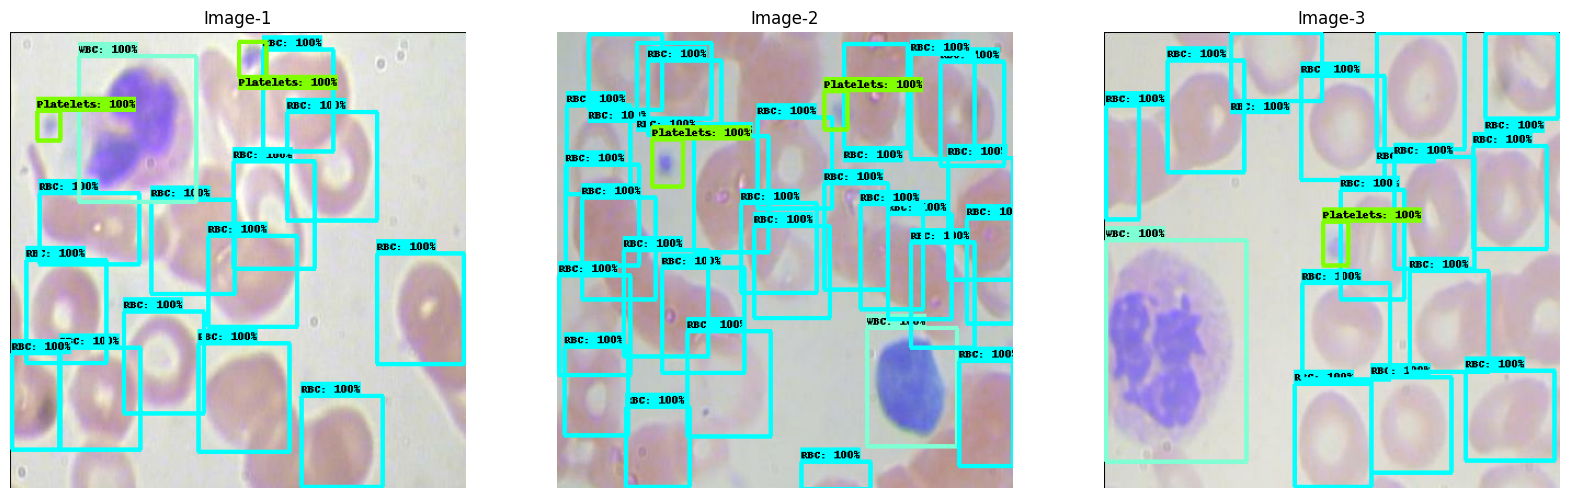

In [21]:
buffer_size = 20
num_of_examples = 3

raw_records = tf.data.TFRecordDataset(
    exp_config.task.train_data.input_path).shuffle(
        buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records, num_of_examples)

In [22]:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

2023-04-27 20:38:08.485306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'cond/range/strided_slice' with dtype int32
	 [[{{node cond/range/strided_slice}}]]


restoring or initializing model...
restored model from ../trained_model/ckpt-1000.
restored from checkpoint: ../trained_model/ckpt-1000
 eval | step:   1000 | running 100 steps of evaluation...


2023-04-27 20:38:13.152795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-04-27 20:38:13.152983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-04-27 20:38:13.471652: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-04-27 20:38:13.472078: I tensorflow/core/common_runtime/executor.cc:1197] [/devi

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.05s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '../trained_model/'
